In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from itertools import product


In [2]:
df = pd.read_csv('Microsoft_Stock.csv')
df

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [4]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...
2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455


Let us use the close price for our analysi

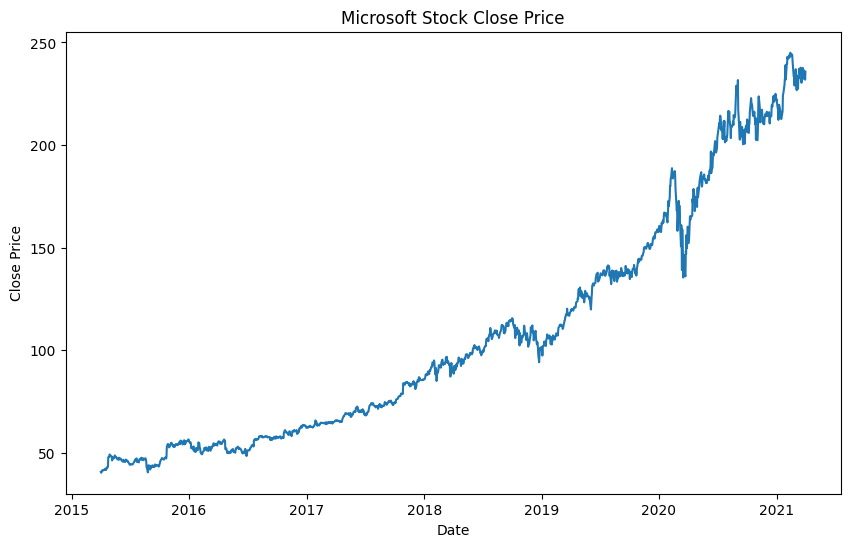

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(df['Close'])
plt.title('Microsoft Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [6]:
ts = df['Close']

In [7]:
ts

Date
2015-04-01 16:00:00     40.72
2015-04-02 16:00:00     40.29
2015-04-06 16:00:00     41.55
2015-04-07 16:00:00     41.53
2015-04-08 16:00:00     41.42
                        ...  
2021-03-25 16:00:00    232.34
2021-03-26 16:00:00    236.48
2021-03-29 16:00:00    235.24
2021-03-30 16:00:00    231.85
2021-03-31 16:00:00    235.77
Name: Close, Length: 1511, dtype: float64

We need to fill 3 parameters - p,d,q
p - autoregression parameter
d - differencing parameter
q - moving average parameter

Augmented Dickey - Fuller Test

In [8]:
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

In [9]:
print("Testing stationarity of the original series:")
test_stationarity(ts)

Testing stationarity of the original series:
ADF Statistic: 1.7371362899271037
p-value: 0.9982158366942122
Critical Values: {'1%': -3.4347582315402434, '5%': -2.863486949792871, '10%': -2.567806534528638}


if p-value is less than 0.05 we would've considered it stationary, but since it is not the time series is not stationary

In [10]:
ts_diff = ts.diff().dropna()
print("\nTesting stationarity of the differenced series:")
test_stationarity(ts_diff)


Testing stationarity of the differenced series:
ADF Statistic: -10.038331065146357
p-value: 1.5195939917535664e-17
Critical Values: {'1%': -3.43476120520139, '5%': -2.863488262178673, '10%': -2.567807233388883}


The time series has now become stationary

ACF and PACF for the p and q values

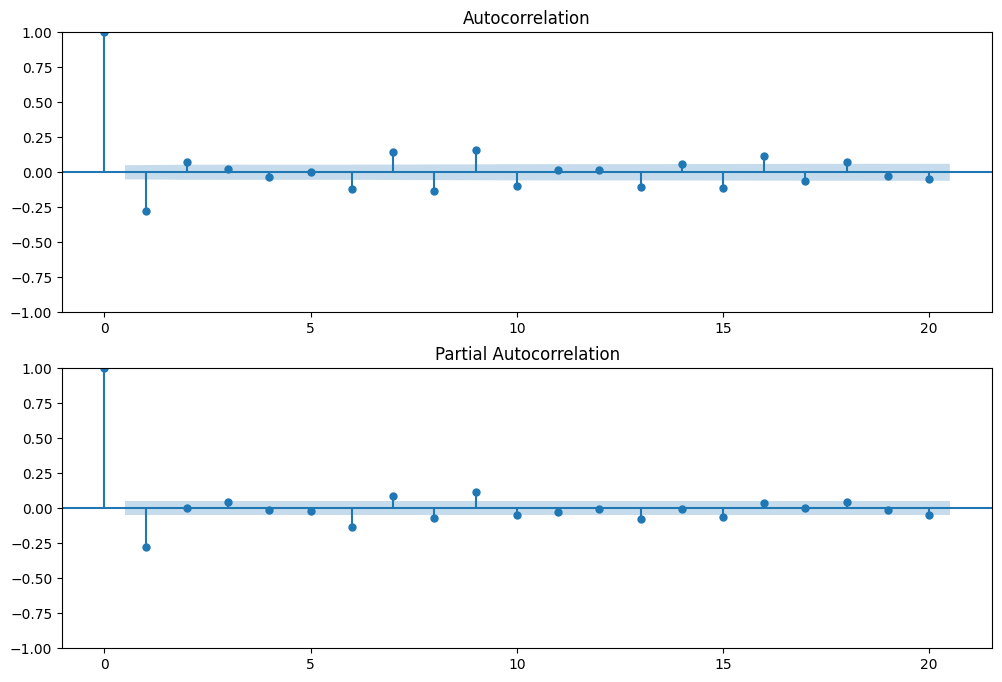

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(ts_diff, ax=ax1, lags=20)
plot_pacf(ts_diff, ax=ax2, lags=20)
plt.show()


p (AR term): Look at the PACF plot. The lag at which the PACF plot cuts off (drops to zero) is the value of p.
q (MA term): Look at the ACF plot. The lag at which the ACF plot cuts off (drops to zero) is the value of q.
It seems as though the values would be p = 1, q = 1 and d = 1

Do a grid search to evaluate the ARIMA model

In [12]:
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Calculate out of sample error
    mse = ((np.array(test) - np.array(predictions)) ** 2).mean()
    return mse


In [13]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p, d, q in product(p_values, d_values, q_values):
        order = (p,d,q)
        try:
            mse = evaluate_arima_model(dataset, order)
            if mse < best_score:
                best_score, best_cfg = mse, order
            print('ARIMA%s MSE=%.3f' % (order,mse))
        except:
            continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [14]:
p_values = [1, 2]
d_values = [1]
q_values = [1, 2]

In [ ]:
best_order = evaluate_models(ts.values, p_values, d_values, q_values)

ARIMA(1, 1, 1) MSE=12.923


In [19]:
best_model = ARIMA(ts, order=best_order)
results = best_model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1511
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3380.778
Date:                Fri, 11 Oct 2024   AIC                           6769.557
Time:                        12:17:37   BIC                           6790.836
Sample:                             0   HQIC                          6777.482
                               - 1511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1600      0.477      0.335      0.737      -0.775       1.094
ar.L2          0.1349      0.125      1.079      0.280      -0.110       0.380
ma.L1         -0.4259      0.477     -0.892      0.3

/Users/surya/anaconda3/envs/Tf-metal/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/surya/anaconda3/envs/Tf-metal/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/surya/anaconda3/envs/Tf-metal/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/surya/anaconda3/envs/Tf-metal/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters 

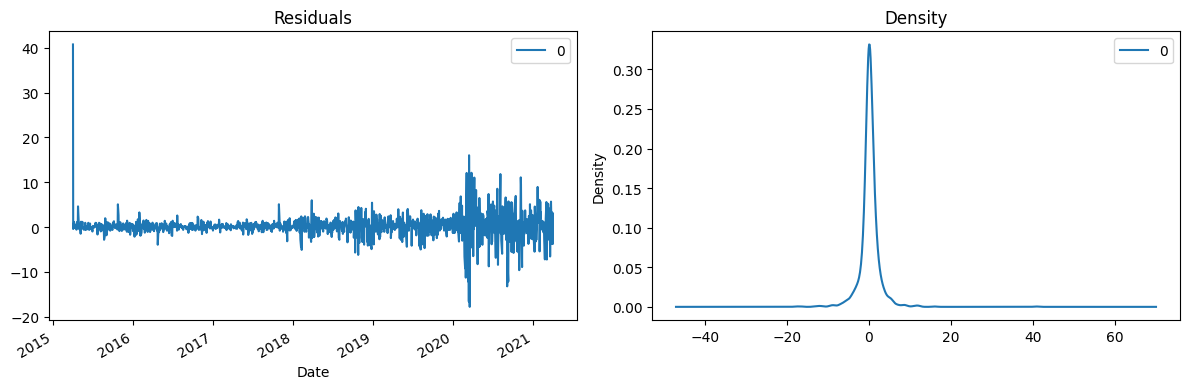

In [20]:
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2, figsize=(12,4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()


In [21]:
forecast = results.forecast(steps=5)
print("5-day forecast:")
print(forecast)


5-day forecast:
1511    234.653225
1512    235.003423
1513    234.908779
1514    234.940884
1515    234.933251
Name: predicted_mean, dtype: float64


/Users/surya/anaconda3/envs/Tf-metal/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/surya/anaconda3/envs/Tf-metal/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
